In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import sklearn.metrics
import time

import faiss  # KNN testing - python 3.5 only?
from scipy.stats import mode

import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA

In [3]:


os_dir = os.path.abspath('')
os_dir_data = os.path.join(os_dir, r"data/original/")

test_csv_path = os_dir_data + "1000_test.csv"
train_csv_path = os_dir_data + "1000_train.csv"

header_list = ["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26"]

test_df = pd.read_csv(test_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header
train_df = pd.read_csv(train_csv_path, names=header_list, skiprows=[0])  # skip row 0 because we are creating our own header



In [4]:
from sklearn.preprocessing import MinMaxScaler

print(test_df.shape)
print(train_df.shape)

####### scale data

df_columns = list(test_df.columns)

df_columns_features = df_columns
df_columns_label = df_columns[0]
df_columns_features.pop(0)


print(df_columns_features)
print(type(df_columns_features))

scaler = StandardScaler()
# scaler = MinMaxScaler()
test_df[df_columns_features] = scaler.fit_transform(test_df[df_columns_features])
train_df[df_columns_features] = scaler.fit_transform(train_df[df_columns_features])

####### end scale data

(3500000, 28)
(7000000, 28)
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26']
<class 'list'>


In [5]:
n_samples = 1000000  # 1000000

####### Separate the label from the normal dataframe

test_subsample_df = test_df.sample(n=n_samples, random_state=1)
train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
#######


###### Perform PCA on the subsample (if desired)
do_perform_pca = False
if do_perform_pca:
    pca = PCA(.95, random_state=1)

    pca.fit(train_subsample_df)  # fit pca on training set

    print(f"Total shape: {len(train_subsample_df.columns)}, PCA Component count: {pca.components_.shape}")

    # transform the test and train
    train_subsample_df = pca.transform(train_subsample_df)
    test_subsample_df = pca.transform(test_subsample_df)

In [9]:
label_1_weight = 1
label_0_weight = 1.4
sample_weights_arr = np.where(train_subsample_label_arr == 1, label_1_weight, label_0_weight)

clf_LR_original = LogisticRegressionCV(cv=5,Cs=20, penalty="l2", random_state=1, solver="lbfgs", max_iter=300, n_jobs=-1)
clf_LR_original = clf_LR_original
clf_LR_original.fit(train_subsample_df, train_subsample_label_arr, sample_weights_arr)

report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_LR_original.predict_proba(test_subsample_df)[:,1])
print(f"{report_LR_roc_auc}")
print(f"Took iterations: {clf_LR_original.n_iter_}")

pred_labels = np.array(clf_LR_original.predict(test_subsample_df))
report_LR = sklearn.metrics.classification_report(y_true = test_subsample_label_arr, y_pred = pred_labels, digits=4)
print(report_LR)


0.9611652253705477
Took iterations: [[[18 15 14 12 11  8  5  5  2  2  1  1  1  1  1  1  1  1  1  1]
  [17 16 14 12 11  8  5  5  2  2  1  1  1  1  1  1  1  1  1  1]
  [18 15 14 12 11  8  5  5  2  2  1  1  1  1  1  1  1  1  1  1]
  [18 16 14 12 11  8  7  5  2  2  1  1  1  1  1  1  1  1  1  1]
  [18 15 14 12 11  8  5  5  2  2  1  1  1  1  1  1  1  1  1  1]]]
              precision    recall  f1-score   support

         0.0     0.8966    0.9138    0.9051    500182
         1.0     0.9120    0.8945    0.9032    499818

    accuracy                         0.9042   1000000
   macro avg     0.9043    0.9042    0.9042   1000000
weighted avg     0.9043    0.9042    0.9042   1000000



(5, 20, 28)
(20, 28)


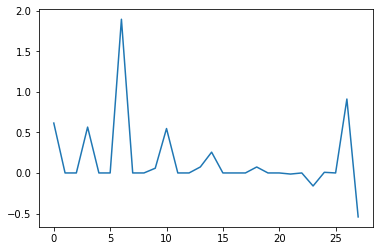

[[ 6.56683973e-01  4.61316873e-07  0.00000000e+00  6.06326060e-01
  -1.53171068e-03  2.91854101e-02  1.93741005e+00 -4.41080356e-03
   0.00000000e+00  2.08141500e-01  5.86287442e-01  3.51794256e-03
  -2.03395700e-03  2.27484021e-01  2.63467741e-01  1.16778256e-03
   3.20330193e-03  1.38655204e-01  1.08517481e-01  0.00000000e+00
  -3.41727532e-07  5.67793882e-02  9.82394995e-02 -3.08125264e-01
   2.45545328e-02  3.91007709e-03  1.00186753e+00]]


In [29]:
paths = clf_LR_reg.coefs_paths_

paths = paths[1.0]
print(paths.shape)

paths_mean = np.mean(paths, axis=0)
print(paths_mean.shape)

fig, ax = plt.subplots()
ax.plot(np.arange(0, 28),paths_mean[1])
# plt.xlabel('Training Sample Count')
# plt.ylabel('AUC Values')
# ax.set_xticks(n_samples_arr*2)
plt.show()

print(clf_LR_reg.coef_)

In [6]:
############## Logistic Regression
# Base LR CV 

class_weight_dict = {1: 1, 0:1}

print("Starting Logistic Regression CV")
# Cross validation to find the best regularization strength first
penalty_terms = ["l1","l2","elasticnet"]

l1_ratio_arr = [.1,.3,.5,.7,.9]

for pentalty_term in penalty_terms:
    if pentalty_term == "l2":
        solver_arr = ["lbfgs","liblinear","sag","saga"]  # note: newton-cg has issues with convergence
        for solver in solver_arr:
            print(f"On: {pentalty_term} | {solver}")
            time1 = time.time()
            clf_LR_original = LogisticRegressionCV(cv=5,Cs=20, penalty=pentalty_term, random_state=1, class_weight=class_weight_dict, solver=solver, max_iter=200)  # TODO: test out different Cs values?

            clf_LR_reg = clf_LR_original

            clf_LR_reg.fit(train_subsample_df, train_subsample_label_arr)

            report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_LR_reg.predict_proba(test_subsample_df)[:,1])
            print(f"{report_LR_roc_auc} | {time.time()-time1}")

    elif pentalty_term == "elasticnet":
        print(f"On: {pentalty_term} | saga")
        time1 = time.time()
        clf_LR_original = LogisticRegressionCV(cv=5,Cs=20, penalty=pentalty_term, random_state=1, class_weight=class_weight_dict, solver="saga", max_iter=200, l1_ratios=l1_ratio_arr)  # TODO: test out different Cs values?

        clf_LR_reg = clf_LR_original

        clf_LR_reg.fit(train_subsample_df, train_subsample_label_arr)

        report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_LR_reg.predict_proba(test_subsample_df)[:,1])
        print(f"{report_LR_roc_auc} | {time.time()-time1}")
    else:
        solver_arr = ["liblinear","saga"]
        for solver in solver_arr:
            print(f"On: {pentalty_term} | {solver}")
            time1 = time.time()
            clf_LR_original = LogisticRegressionCV(cv=5,Cs=20, penalty=pentalty_term, random_state=1, class_weight=class_weight_dict, solver=solver, max_iter=200)  # TODO: test out different Cs values?

            clf_LR_reg = clf_LR_original

            clf_LR_reg.fit(train_subsample_df, train_subsample_label_arr)

            report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_LR_reg.predict_proba(test_subsample_df)[:,1])
            print(f"{report_LR_roc_auc} | {time.time()-time1}")

# LR_best_regularization = float(clf_LR_reg.C_)

# print(f"Best LR Regularization term: {LR_best_regularization}")

Starting Logistic Regression CV
On: l1 | liblinear
0.9611302072419079 | 673.2462387084961
On: l1 | saga
0.961130162721902 | 532.5042934417725
On: l2 | lbfgs
0.9611186353683747 | 127.98631596565247
On: l2 | liblinear
0.9611198921245413 | 749.3991100788116
On: l2 | sag
0.96111867522838 | 559.5697376728058
On: l2 | saga
0.9611186672203789 | 407.2145240306854
On: elasticnet | saga
0.9611203079445964 | 2376.724447488785


In [8]:
# sample_weights_arr = np.where(train_subsample_label_arr == 1, 1, 1)  # make it weight of 2 if label = 1. Otherwise, make it 0.5.

# clf_LR = clf_LR_original

# # Fitting model
# print("Fitting Model")
# clf_LR_original = LogisticRegressionCV(cv=5,Cs=20, penalty="l2", random_state=1, solver="lbfgs", max_iter=300, n_jobs=-1)


pred_labels = np.array(clf_LR_original.predict(test_subsample_df))
report_LR = sklearn.metrics.classification_report(y_true = test_subsample_label_arr, y_pred = pred_labels, digits=4)
# report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_LR.predict_proba(test_subsample_df)[:,1])
print(report_LR)
# print(report_LR_roc_auc)

###################

NameError: name 'pred_labels' is not defined

In [7]:
sample_weights_arr = np.where(train_subsample_label_arr == 1, 1, 1)
results_dict = dict.fromkeys(np.linspace(0,2,5))

for keys, vals in results_dict.items():
    results_dict[keys] = dict.fromkeys(np.linspace(0,2,5))

max_val = 0
best_l0 = 0
best_l1 = 0
for label_0_weight in np.linspace(1.8,2,3):
    for label_1_weight in np.linspace(.1,2,20):

        if label_0_weight == label_1_weight or label_0_weight < label_1_weight - .5:
            continue  # will be the same each time
        print(f"Label 0: {label_0_weight}| Label 1: {label_1_weight}")
        sample_weights_arr = np.where(train_subsample_label_arr == 1, label_1_weight, label_0_weight)
        clf_LR_original.fit(train_subsample_df, train_subsample_label_arr, sample_weights_arr)
        probs = clf_LR_original.predict_proba(test_subsample_df)[:,1]
        report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=probs)

        # results_dict[label_0_weight][label_1_weight] = report_LR_roc_auc

        if report_LR_roc_auc > max_val:
            max_val = report_LR_roc_auc
            best_l0 = label_0_weight
            best_l1 = label_1_weight

        print(f"{report_LR_roc_auc}")
print(f"Best L0: {best_l0}, Best L1: {best_l1}, AUC: {max_val}")

Label 0: 1.8| Label 1: 0.1
0.9596854631344851
Label 0: 1.8| Label 1: 0.2
0.9602796739412158
Label 0: 1.8| Label 1: 0.3
0.9605873625339831
Label 0: 1.8| Label 1: 0.4
0.9607761823550011
Label 0: 1.8| Label 1: 0.5
0.9609018260996484
Label 0: 1.8| Label 1: 0.6
0.9609885472671386
Label 0: 1.8| Label 1: 0.7
0.9610497154872432
Label 0: 1.8| Label 1: 0.7999999999999999
0.9610940289491144
Label 0: 1.8| Label 1: 0.8999999999999999
0.9611233971010056
Label 0: 1.8| Label 1: 0.9999999999999999
0.9611439144797241
Label 0: 1.8| Label 1: 1.0999999999999999
0.9611492397324296
Label 0: 1.8| Label 1: 1.2
0.9611628671182352
Label 0: 1.8| Label 1: 1.3
0.9611635874303306
Label 0: 1.8| Label 1: 1.4
0.9610875624082575
Label 0: 1.8| Label 1: 1.5
0.9611422796475073
Label 0: 1.8| Label 1: 1.5999999999999999
0.9610746724465498
Label 0: 1.8| Label 1: 1.7
0.9611234810090168
Label 0: 1.8| Label 1: 1.9
0.9611144308958177
Label 0: 1.8| Label 1: 2.0
0.961098531213711
Label 0: 1.9| Label 1: 0.1
0.9596373468281099
Label 

In [82]:
# Adjust weights based on prediction accuracy, not predict proba:

# incorrect_indicies = np.where(pred_labels != train_subsample_label_arr)
# correct_indicies = np.where(pred_labels == train_subsample_label_arr)

# sample_weights_arr = np.where(train_subsample_label_arr == 1, 1, 1)

clf_LR = clf_LR_original

sample_weights_arr = np.ones(n_samples*2)

diff_arr = pred_labels - test_subsample_label_arr  # if same, then 0 -> if correct, then zero.

incorrect_indicies = np.array(np.nonzero(diff_arr)).ravel()
correct_indicies = np.where(diff_arr == 0)[0]

print(incorrect_indicies.shape, correct_indicies.shape)

# sample_weights_arr[correct_indicies] = sample_weights_arr[correct_indicies] - .5
# sample_weights_arr[incorrect_indicies] = sample_weights_arr[incorrect_indicies] + .5

sample_weights_arr.put(correct_indicies,.5)
sample_weights_arr.put(incorrect_indicies,1.5)

# sample_weights_arr[correct_indicies] = .5
# sample_weights_arr[incorrect_indicies] = 1.5

print(sample_weights_arr)

clf_LR_adj = LogisticRegression(C=LR_best_regularization,penalty="l2", random_state=1)
clf_LR_adj.fit(train_subsample_df, train_subsample_label_arr.ravel(), sample_weight=sample_weights_arr)
pred_labels_adj = np.array(clf_LR_adj.predict(test_subsample_df))

report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_LR_adj.predict_proba(test_subsample_df)[:,1])
print(report_LR)
print(report_LR_roc_auc)

######

(19149,) (180851,)
[1.5 0.5 0.5 ... 0.5 0.5 0.5]
              precision    recall  f1-score   support

         0.0     0.9138    0.8930    0.9033    100105
         1.0     0.8951    0.9156    0.9052     99895

    accuracy                         0.9043    200000
   macro avg     0.9045    0.9043    0.9042    200000
weighted avg     0.9045    0.9043    0.9042    200000

0.9596681474341323


Predict Prob a testing below

In [7]:


# # predict_proba attempt to optimize sample_weights for edge prediction cases
# pred_probs_LR = clf_LR.predict_proba(train_df)  # check on train data to reweight
# print(pred_probs_LR.shape)

# pred_probs_LR_diff = np.abs(np.diff(pred_probs_LR, axis=1))

# # High values need to lose weight. Low values need to gain weight.
# min_weight = .4
# max_weight = .6

# pred_probs_LR_diff_proportion = (1 - pred_probs_LR_diff) * (max_weight-min_weight) + min_weight
# pred_probs_LR_diff_proportion = pred_probs_LR_diff_proportion.ravel()

# print(pred_probs_LR_diff_proportion.shape)

# print("new range ",np.min(pred_probs_LR_diff_proportion), np.max(pred_probs_LR_diff_proportion))

# clf_LR = LogisticRegression(C=LR_best_regularization,penalty="l2", random_state=1)
# clf_LR.fit(train_df, train_label_arr.ravel(), sample_weight=pred_probs_LR_diff_proportion)
# pred_labels_adj = np.array(clf_LR.predict(test_df))

# report_LR_adj = sklearn.metrics.classification_report(y_true = test_label_arr, y_pred = pred_labels_adj, digits=4)
# print(report_LR_adj)

# ############## 

# ###### test
# # predict_proba attempt to optimize sample_weights for edge prediction cases
# pred_probs_LR = clf_LR.predict_proba(train_df)  # check on train data to reweight
# print(pred_probs_LR.shape)

# pred_probs_LR_diff = np.abs(np.diff(pred_probs_LR, axis=1))

# # High values need to lose weight. Low values need to gain weight.
# min_weight = .3
# max_weight = .7

# pred_probs_LR_diff_proportion = (1 - pred_probs_LR_diff) * (max_weight-min_weight) + min_weight
# pred_probs_LR_diff_proportion = pred_probs_LR_diff_proportion.ravel()

# print(pred_probs_LR_diff_proportion.shape)

# print("new range ",np.min(pred_probs_LR_diff_proportion), np.max(pred_probs_LR_diff_proportion))

# clf_LR = LogisticRegression(C=LR_best_regularization,penalty="l2", random_state=1)
# clf_LR.fit(train_df, train_label_arr.ravel(), sample_weight=pred_probs_LR_diff_proportion)
# pred_labels_adj = np.array(clf_LR.predict(test_df))

# report_LR_adj = sklearn.metrics.classification_report(y_true = test_label_arr, y_pred = pred_labels_adj, digits=4)
# print(report_LR_adj)

# ######

# ###### test
# # predict_proba attempt to optimize sample_weights for edge prediction cases
# pred_probs_LR = clf_LR.predict_proba(train_df)  # check on train data to reweight
# print(pred_probs_LR.shape)

# pred_probs_LR_diff = np.abs(np.diff(pred_probs_LR, axis=1))

# # High values need to lose weight. Low values need to gain weight.
# min_weight = .2
# max_weight = .8

# pred_probs_LR_diff_proportion = (1 - pred_probs_LR_diff) * (max_weight-min_weight) + min_weight
# pred_probs_LR_diff_proportion = pred_probs_LR_diff_proportion.ravel()

# print(pred_probs_LR_diff_proportion.shape)

# print("new range ",np.min(pred_probs_LR_diff_proportion), np.max(pred_probs_LR_diff_proportion))

# clf_LR = LogisticRegression(C=LR_best_regularization,penalty="l2", random_state=1)
# clf_LR.fit(train_df, train_label_arr.ravel(), sample_weight=pred_probs_LR_diff_proportion)
# pred_labels_adj = np.array(clf_LR.predict(test_df))

# report_LR_adj = sklearn.metrics.classification_report(y_true = test_label_arr, y_pred = pred_labels_adj, digits=4)
# print(report_LR_adj)

# ######

# ###### test
# # predict_proba attempt to optimize sample_weights for edge prediction cases
# pred_probs_LR = clf_LR.predict_proba(train_df)  # check on train data to reweight
# print(pred_probs_LR.shape)

# pred_probs_LR_diff = np.abs(np.diff(pred_probs_LR, axis=1))

# # High values need to lose weight. Low values need to gain weight.
# min_weight = .1
# max_weight = .9

# pred_probs_LR_diff_proportion = (1 - pred_probs_LR_diff) * (max_weight-min_weight) + min_weight
# pred_probs_LR_diff_proportion = pred_probs_LR_diff_proportion.ravel()

# print(pred_probs_LR_diff_proportion.shape)

# print("new range ",np.min(pred_probs_LR_diff_proportion), np.max(pred_probs_LR_diff_proportion))

# clf_LR = LogisticRegression(C=LR_best_regularization,penalty="l2", random_state=1)
# clf_LR.fit(train_df, train_label_arr.ravel(), sample_weight=pred_probs_LR_diff_proportion)
# pred_labels_adj = np.array(clf_LR.predict(test_df))

# report_LR_adj = sklearn.metrics.classification_report(y_true = test_label_arr, y_pred = pred_labels_adj, digits=4)
# print(report_LR_adj)

# ######

###### test
# predict_proba attempt to optimize sample_weights for edge prediction cases
pred_probs_LR = clf_LR.predict_proba(train_df)  # check on train data to reweight
print(pred_probs_LR.shape)

pred_probs_LR_diff = np.abs(np.diff(pred_probs_LR, axis=1))

# High values need to lose weight. Low values need to gain weight.
min_weight = 0
max_weight = 1

pred_probs_LR_diff_proportion = (1 - pred_probs_LR_diff) * (max_weight-min_weight) + min_weight
pred_probs_LR_diff_proportion = pred_probs_LR_diff_proportion.ravel()

print(pred_probs_LR_diff_proportion.shape)

print("new range ",np.min(pred_probs_LR_diff_proportion), np.max(pred_probs_LR_diff_proportion))

clf_LR = LogisticRegression(C=LR_best_regularization,penalty="l2", random_state=1)
clf_LR.fit(train_df, train_label_arr.ravel(), sample_weight=pred_probs_LR_diff_proportion)
pred_labels_adj = np.array(clf_LR.predict(test_df))

report_LR_adj = sklearn.metrics.classification_report(y_true = test_label_arr, y_pred = pred_labels_adj, digits=4)
print(report_LR_adj)

######

ValueError: X has 28 features per sample; expecting 27

In [5]:
# Find the optimal sample size (done - 1 million test/2 mill train)

class_weight_dict = {1: 1, 0:1}

print("Starting Logistic Regression CV")
# Cross validation to find the best regularization strength first
clf_LR_original = LogisticRegressionCV(cv=5,Cs=20, penalty="l2", random_state=1, class_weight=class_weight_dict, n_jobs=-1)  # TODO: test out different Cs values?

n_samples_arr = [100000,500000,1000000,1500000,2000000,2500000, 3000000,3500000]
# n_samples_arr = [1000,2000,3000]

n_samples_arr = np.array(n_samples_arr)
time_arr = []
auc_arr = []
for n_samples in n_samples_arr:
    ####### Separate the label from the normal dataframe
    test_subsample_df = test_df.sample(n=n_samples, random_state=1)
    train_subsample_df = train_df.sample(n=n_samples*2, random_state=1)

    test_subsample_label_arr = np.array(test_subsample_df[df_columns_label])
    test_subsample_df = test_subsample_df.drop(columns=df_columns_label)

    train_subsample_label_arr = np.array(train_subsample_df[df_columns_label])
    train_subsample_df = train_subsample_df.drop(columns=df_columns_label)
    #######

    clf_LR = clf_LR_original

    time1 = time.time()

    print(f"On: {n_samples}")

    clf_LR.fit(train_subsample_df, train_subsample_label_arr)
    # LR_best_regularization = float(clf_LR.C_)
    # print(f"Best LR Regularization term: {LR_best_regularization}")

    # # Fitting model
    # print("Fitting Model")
    # clf_LR = LogisticRegression(C=LR_best_regularization,penalty="l2", random_state=1)  # class weights if fed in here act as multipliers for the sample weights
    # clf_LR.fit(train_subsample_df, train_subsample_label_arr.ravel())
    pred_labels = np.array(clf_LR.predict(test_subsample_df))

    # report_LR = sklearn.metrics.classification_report(y_true = test_subsample_label_arr, y_pred = pred_labels, digits=4)
    report_LR_roc_auc = sklearn.metrics.roc_auc_score(y_true = test_subsample_label_arr, y_score=clf_LR.predict_proba(test_subsample_df)[:,1])
    # print(report_LR)
    print(report_LR_roc_auc)

    auc_arr.append(report_LR_roc_auc)
    time_arr.append(time.time()-time1)

    ###################

#print(n_samples_arr, time_arr, auc_arr)

fig, ax = plt.subplots()
ax.plot(n_samples_arr*2, time_arr)
plt.xlabel('Training Sample Count')
plt.ylabel('Time to Run')
ax.set_xticks(n_samples_arr*2)
plt.show()

fig, ax = plt.subplots()
ax.plot(n_samples_arr*2, auc_arr)
plt.xlabel('Training Sample Count')
plt.ylabel('AUC Values')
ax.set_xticks(n_samples_arr*2)
plt.show()

Starting Logistic Regression CV
On: 100000
0.9595364475852252
On: 500000
0.9607344402369297
On: 1000000
0.9611188512724034
On: 1500000
0.9611260629123828
On: 2000000
0.9612023241830305
On: 2500000
0.9612137580686269
On: 3000000
0.9611740632881919
On: 3500000
